<a href="https://colab.research.google.com/github/mit-riya/Neural-Style-Transfer/blob/main/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Style Transfer

In [1]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
root_path = '/content/drive/MyDrive/Neural Style Transfer'

In [5]:
# Importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import models
from torch import optim
from PIL import Image
from torchvision import transforms as T

In [30]:
# Loading the pre-trained VGG 19 model

vgg=models.vgg19(weights='VGG19_Weights.DEFAULT')
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [31]:
# Removing the classifier layers as we need only features for neural style transfer

vgg=vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [32]:
# Freezing the model so that no weights or biases are updated during training and using only pretrained weights

for params in vgg.parameters():
  params.requires_grad_(False)

In [33]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [34]:
# Moving model to gpu
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [35]:
# Image preprocessing

def preprocess(img_path,max_size=500):
  image=Image.open(img_path).convert('RGB')
  if max(image.size)>max_size:
    size=max_size
  else:
    size=max(image.size)
  img_transforms=T.Compose([
      T.Resize(size),
      T.ToTensor(),
      T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
  ])

  image=img_transforms(image)
  image=image.unsqueeze(0)
  return image

In [36]:
# Getting content and style image

content_p=preprocess(root_path+'/content4.jpg')
style_p=preprocess(root_path+'/style3.jpg')

content_p=content_p.to(device)
style_p=style_p.to(device)
print("Content Shape",content_p.shape)
print("Style Shape",style_p.shape)

Content Shape torch.Size([1, 3, 651, 500])
Style Shape torch.Size([1, 3, 500, 765])


In [37]:
# Deprocessing Image

def deprocess(tensor):
  image=tensor.to("cpu").clone()
  image=image.numpy()
  image=image.squeeze(0)
  image=image.transpose(1,2,0)
  image=image*np.array([0.229,0.224,0.225])+np.array([0.485,0.456,0.406])     #denormalisation
  image=image.clip(0,1)
  return image

In [38]:
content_d=deprocess(content_p)
style_d=deprocess(style_p)

print("Deprocess content: ",content_d.shape)
print("Deprocess style: ",style_d.shape)


Deprocess content:  (651, 500, 3)
Deprocess style:  (500, 765, 3)


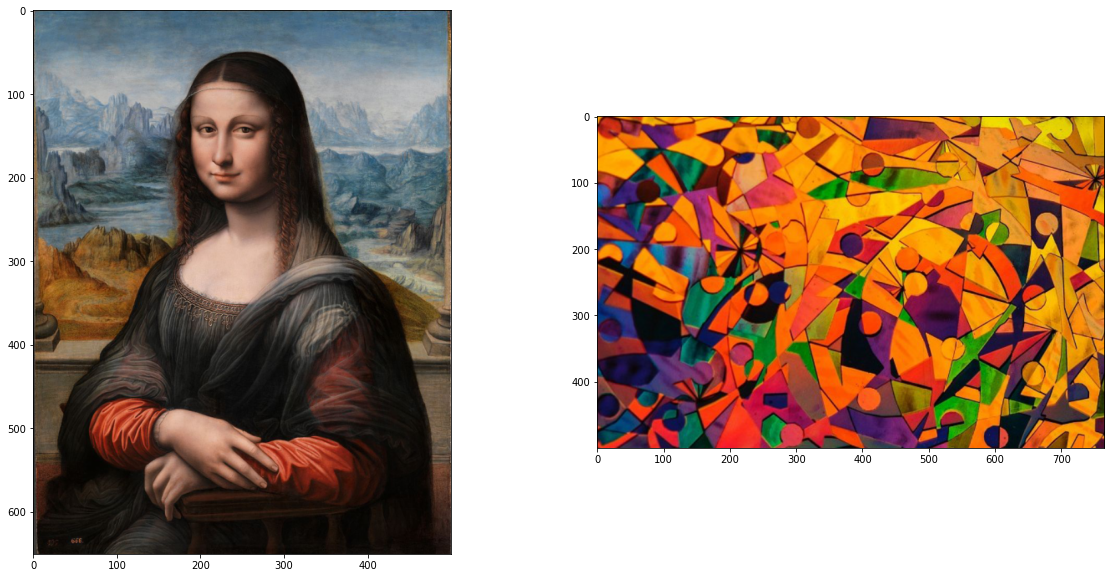

In [39]:
# Showing content and style image

fig, (ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(content_d)
ax2.imshow(style_d)

In [40]:
# Getting content and style features

def get_features(image,model):
  layers={
      '0':'conv1_1',
      '5':'conv2_1',
      '10':'conv3_1',
      '19':'conv4_1',
      '21':'conv4_2', #content feature
      '28':'conv5_1'
  }

  x=image
  Features={}
  for name,layer in model._modules.items():
    x=layer(x)
    if name in layers:
      Features[layers[name]]=x

  return Features

In [41]:
content_f=get_features(content_p,vgg)
style_f=get_features(style_p,vgg)

In [42]:
# Creating gram matrix

def gram_matrix(tensor):
  b,c,h,w=tensor.size()
  tensor=tensor.view(c,h*w)
  gram=torch.mm(tensor,tensor.t())
  return gram

In [43]:
style_grams={layer:gram_matrix(style_f[layer]) for layer in style_f}

In [44]:
# Calculating content loss

def content_loss(target_conv4_2,content_conv4_2):
  loss=torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [45]:
# Initializing style weights

style_weights={
    'conv1_1':1.0,
    'conv2_1':0.75,
    'conv3_1':0.2,
    'conv4_1':0.2,
    'conv5_1':0.2
}

In [46]:
# Calculating style loss

def style_loss(style_weights,target_features,style_grams):
  loss=0
  for layer in style_weights:
    target_f=target_features[layer]
    target_gram=gram_matrix(target_f)
    style_gram=style_grams[layer]
    b,c,h,w=target_f.shape
    layer_loss=style_weights[layer]*torch.mean((target_gram-style_gram)**2)
    loss+=layer_loss/(c*h*w)
  return loss

In [47]:
# Initializing the target image as the content image
target=content_p.clone().requires_grad_(True).to(device)
target_f=get_features(target,vgg)
print("Content Loss:",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("Style Loss:",style_loss(style_weights,target_f,style_grams))

Content Loss: tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
Style Loss: tensor(2167.9504, device='cuda:0', grad_fn=<AddBackward0>)


In [48]:
# Defining constants for further use

optimizer=optim.Adam([target],lr=0.003)
alpha=1
beta=1e5
epochs=3000
show_every=500

In [49]:
# Calculating total loss

def total_loss(c_loss,s_loss,alpha,beta):
  loss=alpha*c_loss+beta*s_loss
  return loss

In [50]:
# Training loop

results=[]
for i in range(epochs):
  target_f=get_features(target,vgg)
  c_loss=content_loss(target_f['conv4_2'],content_f['conv4_2'])
  s_loss=style_loss(style_weights,target_f,style_grams)
  t_loss=total_loss(c_loss,s_loss,alpha,beta)

  optimizer.zero_grad()
  t_loss.backward()
  optimizer.step()

  if i%show_every==0:
    print("Total loss at epoch {} : {}".format(i,t_loss))
    results.append(deprocess(target.detach()))

Total loss at epoch 0 : 216795040.0
Total loss at epoch 500 : 36948240.0
Total loss at epoch 1000 : 12914198.0
Total loss at epoch 1500 : 5921045.5
Total loss at epoch 2000 : 3226997.0
Total loss at epoch 2500 : 1974708.125


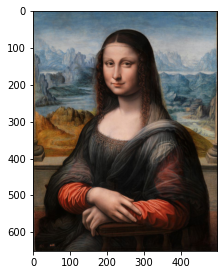

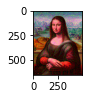

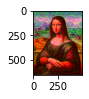

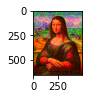

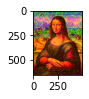

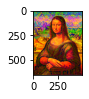

In [51]:
plt.figure(figsize=(15,15))

for i in range(len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
  plt.show()

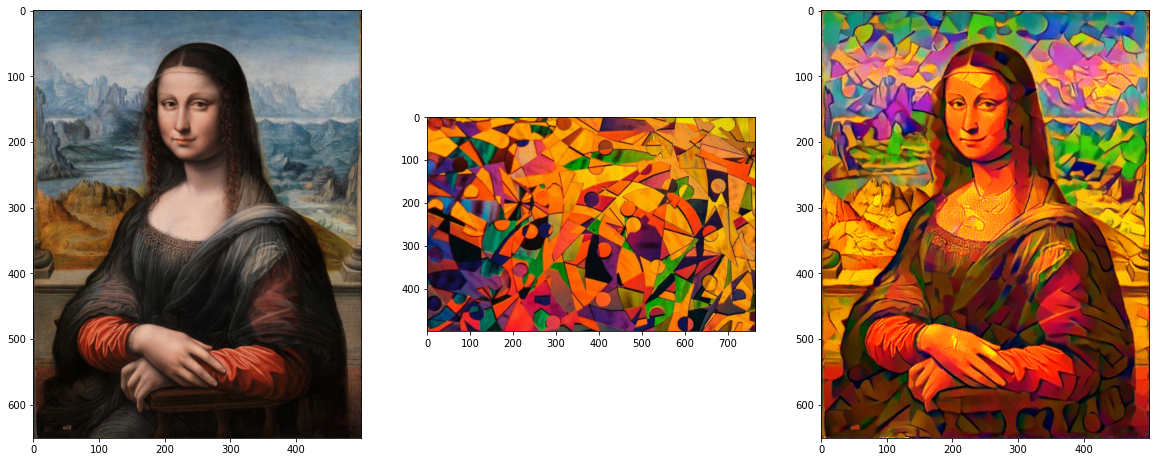

In [52]:
target_copy=deprocess(target.detach())
content_copy=deprocess(content_p)
style_copy=deprocess(style_p)
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,20))
ax1.imshow(content_copy)
ax2.imshow(style_copy)
ax3.imshow(target_copy)